<a href="https://colab.research.google.com/github/helgadenes/Astrophysics_yachay/blob/main/python_tutorials/3D_data_cubes/HI_data_tutorial_HALOGAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with a 3D data cube (Astrophysics)

requirements: astropy, numpy, matplotlib

contents:
- reading in fits data cubes (3D spectral line data - HI data of a galaxy)
- plotting slices of the 3D data cube
- downloading astronomical images from a database (for the same galaxy as the HI data)
- making an overlay of the HI data onto an optical image
- Plotting the HI spectrum of a galaxy
- calculating the HI mass of a galaxy
- making moment maps

## Resources
- Google is your best friend. If you have coding questions, it is likely that someone also had the same question before and there are answers online.
- The documentation of the different python packages, e.g. matplotlib, numpy, astropy is good. You can find a lot of useful information there.
- stackoverflow is a website where people can ask questions of the community. There are generally good solutions there to problems.
- The astropy website has several tutorials and examples that can help you to learn how to do plots and calculations with the package: https://learn.astropy.org/
- There are also several other websites with various free python tutorials

- A collection of lecture notes on Radio astronomy: https://science.nrao.edu/opportunities/courses/era This is a very good resource to learn more about radio astronomy
- usefull information on the spectral lines in general: https://www.cv.nrao.edu/~sransom/web/Ch7.html#E155 This has all the relevant equations

In [1]:
# this installs the relevant packages once uncommented

! pip install reproject
! pip install astroquery==0.4.6
! pip install spectral_cube

In [2]:
# loading in relevant packages
# basic python packages
import numpy as np
import matplotlib.pyplot as plt

# astronomy specific packages
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from reproject import reproject_interp
# getting data from the online image server
from astroquery.skyview import SkyView

# this is to access files from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read in the data file (fits file)
The data used in this tutorial is the publicly available data from the HALOGAS (Hydrogen Accretion in LOcal GAlaxieS) Survey:https://www.astron.nl/halogas/index.php

In particular, the tutarial is using data for the galaxy NGC 925. The data is available from here: https://www.astron.nl/halogas/data.php

This data cube is ~400 MB in size.

In [3]:
# location of the data files
directory = '/content/drive/My Drive/Colab Notebooks/'

file = directory+'/NGC0925-HR-cube.fits'
hdul = fits.open(file)

# Fits files have a header part, which contains the metadata of the file, in this case the details of the observation
h = hdul[0].header

# and a data part, which is esentially an N dimensional matrix with numbers
d = hdul[0].data

## Have a look at the content of the file
print the information in the header
have a look at the shape (dimensions) of the data
have a look at the data

In [4]:
# printing the header / metadata
print(h.keys)

<bound method Header.keys of SIMPLE  =                    T  /                                               
BITPIX  =                  -32  /                                               
NAXIS   =                    3  /                                               
NAXIS1  =                 1025  /                                               
NAXIS2  =                 1025  /                                               
NAXIS3  =                   99  /                                               
EXTEND  =                    T  /                                               
BSCALE  =    1.00000000000E+00  /                                               
BZERO   =    0.00000000000E+00  /                                               
BUNIT   = 'JY/BEAM '  /                                                         
DATE-OBS= '2009-01-03T18:28:48.3'  /                                            
TELESCOP= 'WSRT    '  /                                                         

In [5]:
# checking the data
print(d.shape)
# This is a 3 dimensional data cube: RA, DEC coordinates, frequency

(99, 1025, 1025)


## Plot slices of the cube


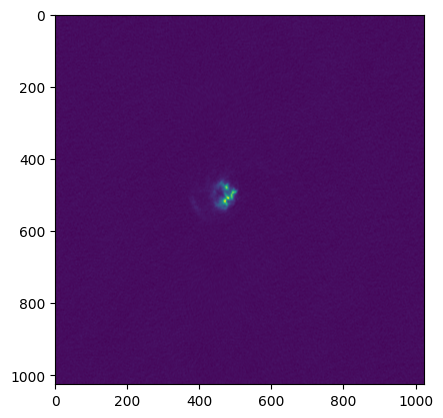

In [6]:
# lets quickly plot slice 30
plt.imshow(d[30,:,:])

### Plot one spatial axis and the frequency axis
This shows how is the gas moving inside the galaxy.

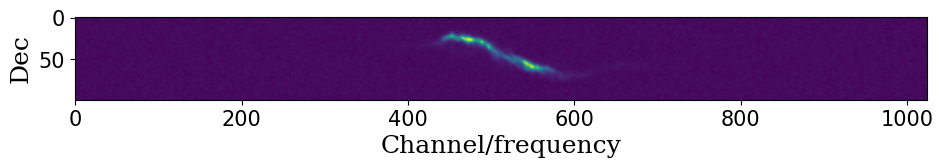

In [7]:
fig = plt.figure(figsize=(11,10))

ax = fig.add_subplot(1,1,1)
plt.imshow(d[:,500,:])
ax.set_xlabel('Channel/frequency', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

## Average some channels

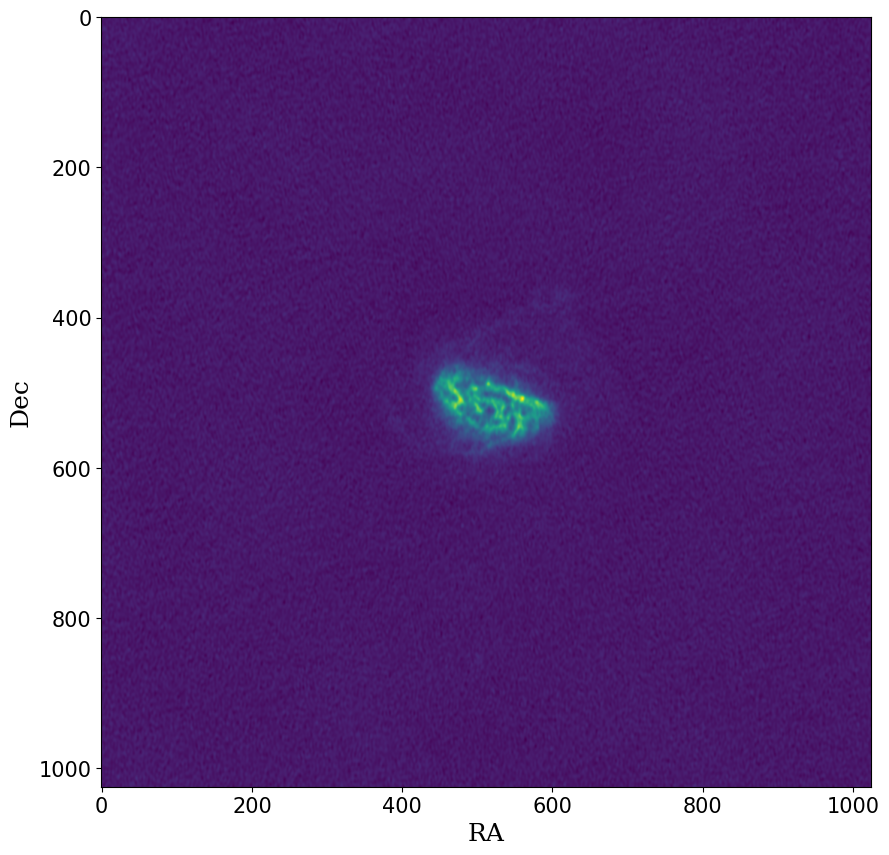

In [8]:
fig = plt.figure(figsize=(11,10))

d_av = np.mean(d, axis=0)

ax = fig.add_subplot(1,1,1)
plt.imshow(d_av)
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

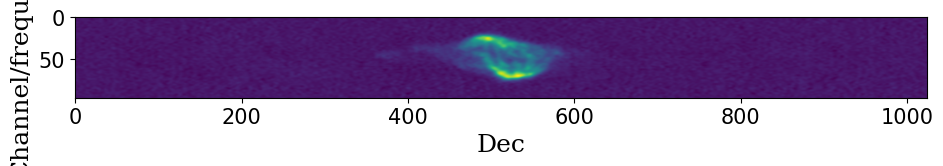

In [9]:
# Let's have a better look at how the gas is moving inside the galaxy

fig = plt.figure(figsize=(11,8))

# Let's sum the data to get a better picture of all the gas in the data cube
d_sum = np.sum(d, axis=2) # axis 2 is the RA

ax = fig.add_subplot(1,1,1)
plt.imshow(d_sum[:-2,:])

ax.set_xlabel('Dec', size=18,family='serif')
ax.set_ylabel('Channel/frequency', size=18,family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

### Calculate the rms of the data
Thsi can be used for a treshold. For example 5 sigma is usually a good lower treshold for detection

In [10]:
def calc_rms(x):
    rms = np.sqrt(np.mean(x**2))
    return rms

rms = calc_rms(d)
print(rms)

0.0004232117


### Save the integrated intensity map (moment 0 map)

In [11]:
d_mom0 = np.sum(d, axis=0)* abs(h['CDELT3'])/1000  # original data

In [12]:
# saving data in a fits file

# first we define some values for the header
wcs_new = WCS(naxis=2)
wcs_new.wcs.cdelt = [h['CDELT1'], h['CDELT2']]
wcs_new.wcs.ctype = [h['CTYPE1'], h['CTYPE2']]
wcs_new.wcs.crval = [h['CRVAL1'], h['CRVAL2']]
wcs_new.wcs.crpix = [h['CRPIX1'], h['CRPIX2']]
header = wcs_new.to_header()

# add the data and the header to an object that can be written into a file
hdul_new = fits.PrimaryHDU(d_mom0, header=header)
hdul_new.writeto(directory+'mom0.fits', overwrite=True)

## Check the saved mom 0 map

In [13]:
# Loading the saved moment 0 map:
file = directory+'/mom0.fits'
hdul_mom0 = fits.open(file)
h_mom0 = hdul_mom0[0].header
d_mom0 = hdul_mom0[0].data

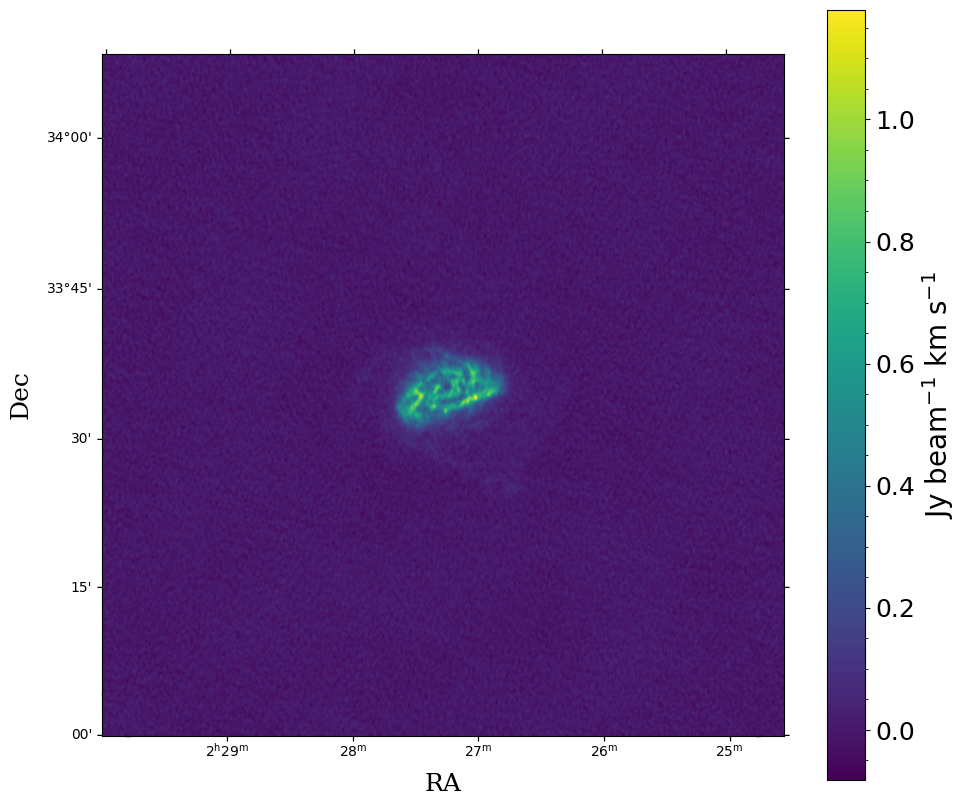

In [14]:
# Making a figure
fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(1,1,1, projection=WCS(h_mom0))  # by using the projection argument and the WCS package you can have the x and y axis in sky coordinates
cb = plt.imshow(d_mom0)
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# adding a colour bar:
cbar =fig.colorbar(cb)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_ylabel(r'Jy beam$^{-1}$ km s$^{-1}$', fontsize=20)

fig.show()


## Make an overlay on an optical image

For this we are going to grab an image from an online data base based on the coordinates of the HI data cube. Then we are going to grid the images to eachother to match the pixels and make the overlay.

In [15]:
# get the central coordinate of the image
# we want to get an optical image with the same coordiantes

c = SkyCoord(h_mom0['CRVAL1'], h_mom0['CRVAL2'], unit="deg")
print(c.to_string('hmsdms'))

02h27m16.90032706s +33d34m45.00457968s


### retrieve optical image from an online archive
We are going to use skyview here

You can check the name of the available survey data here: https://astroquery.readthedocs.io/en/latest/skyview/skyview.html  (this is a list of names that can go into the survey argument)

And you can also use the skyview website directly to check if the particular survey has data for that galaxy: https://skyview.gsfc.nasa.gov/current/cgi/query.pl just type in the name or the coordinates of the galaxy and select the surveys you are interested in.

Genarrly the DSS2 Survey (2nd Digitised Sky Survey) is a good start since it covers the whole sky. 'Blue' referes to the band in which the data was taken. Blue is taken with a filter that lets trough the blue optical light from the galaxy.

(900, 900)
(1025, 1025)


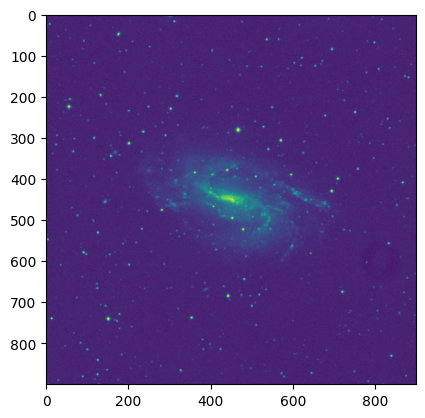

In [16]:
# this line grabs the image from the remote server
# radius specifies the size of the image in degrees
# pixels define how many pixels the image should have (900 x 900 is the maximum)
path = SkyView.get_images(position=c.to_string('hmsdms'), radius=0.3*u.deg, survey=['DSS2 Blue'], pixels=[900,900])

# this line puts the data into a fits image
hdulist_opt = path[0]
d_opt = hdulist_opt[0].data
h_opt = hdulist_opt[0].header


# the dimensions of the data, not the same as the HI image!
print(d_opt.shape)
print(d_mom0.shape)

# quick look
plt.imshow(d_opt)


### Reproject the HI image onto the same pixel grid as the optical image

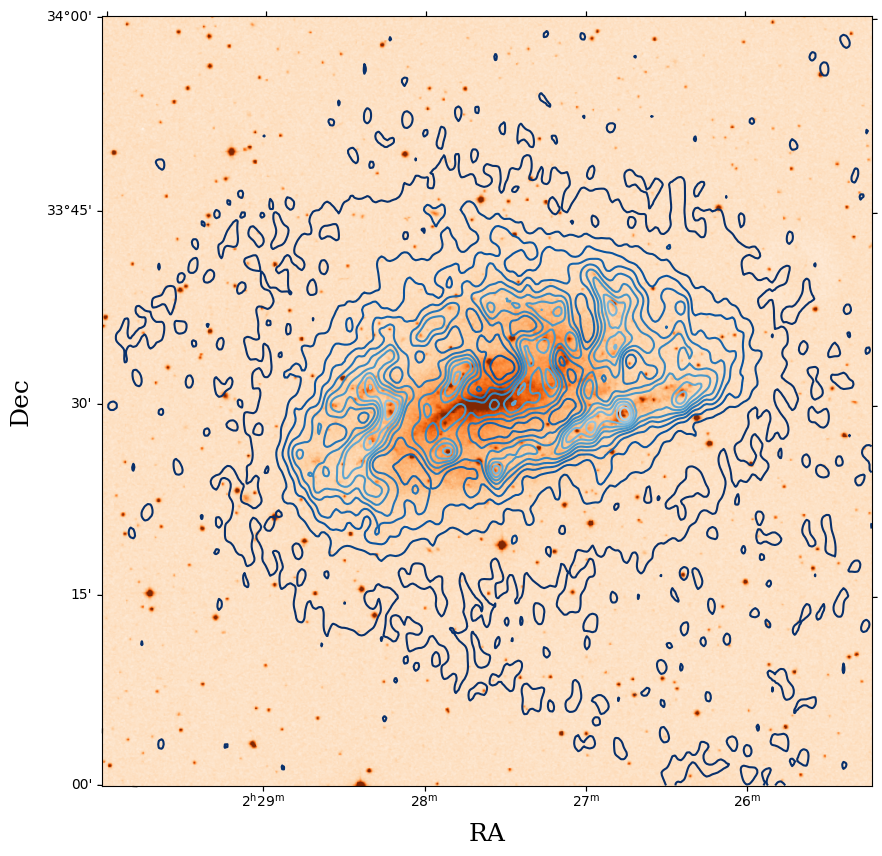

In [17]:
# To make an overlay the two images need to have the same pixel grid
# reproject the data onto the same pixel grid
# we are reprojecting the HI data onto the grid of the optical data, since the resolution of the optical data is better
hi_reprojected, footprint = reproject_interp(hdul_mom0, h_opt)

# calculate the rms (root mean square) of the reprojected HI data, to help drawing contours
rms_mom0 = calc_rms(hi_reprojected)

fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(1,1,1, projection=WCS(h_mom0))
ax.imshow(d_opt, cmap='Oranges', vmax=np.percentile(d_opt, 99.8))
ax.contour(hi_reprojected, levels=np.arange(0.2,8,0.5)*rms_mom0, cmap='Blues_r')
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig.savefig(directory+'/ngc4192_mom0_overlay.png', dpi=200)

# Note that the HI disk is very similar in size to the stellar disk
# This is not typical for spiral galaxies



## Plot the HI spectrum of the galaxy
- plot the spectrum of one spaxel in the data
- average the spectrum in a number of pixels
- average the spectrum based on a criteria (e.g. above 5 sigma detection)

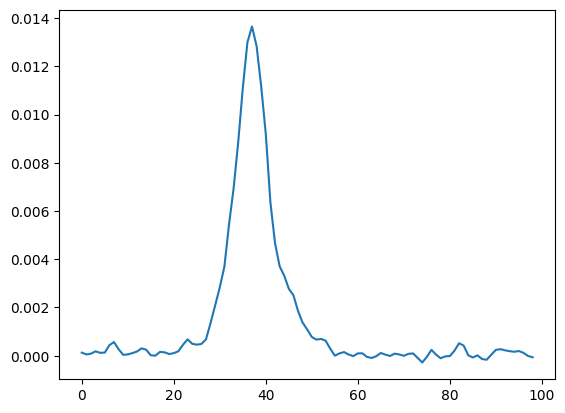

In [18]:
# lets look at the spectrum in one pixel
# Can you see the galaxy?

plt.plot(d[:,500,500])


(99, 1025)
3rd axis type VELO-HEL
3rd axis steps 4119.99988556
3rd axis reference 350000.0
data units JY/BEAM


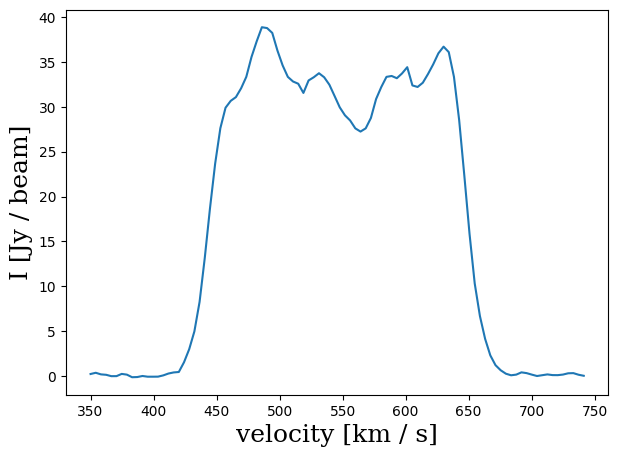

In [20]:
# Sum for the whole cube, but make sure to take the masked data that does not have the noise anymore
# This is the integrated spectral line profile
# Note the typical "dubble horn" shape of the profile, this is showing the rotation of the galaxy

d_av = np.sum(d[:,:,:], axis = 1)
print(d_av.shape)
d_av_3 = np.sum(d_av[:,:], axis = 1)
spectra = d_av_3[:-3]

# checking the units of the spectral axis
print('3rd axis type', h['CTYPE3'])  # the third dimension of this cube is in heliocentric velocity
print('3rd axis steps', h['CDELT3']) # in m/s
print('3rd axis reference', h['CRVAL3']) # in m/s
print('data units', h['BUNIT'])

x_axis = (np.arange(0,len(spectra))*h['CDELT3']+h['CRVAL3']) / 1000 # we also convert to km/s from m/s

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
plt.plot(x_axis, spectra)  # the last channel of the data cube is bad (with very high noise), so we don't include that in the plot
ax.set_xlabel('velocity [km / s]', size=18,family='serif')
ax.set_ylabel('I [Jy / beam]', size=18,family='serif')
plt.savefig(directory+'ngc4192_HI_spectra.png')

## Calculate the HI mass of the galaxy
A good information source on galaxies is the NASA/IPAC Extragalactic Data Base (NED): https://ned.ipac.caltech.edu/

If you search the galaxy NGC 4192, you will find various informatio on it, including: coordinates, optical magnitudes, optical diameter, distance measurments, optical velocity measurment, other names, morpthological identification etc.

This is an extragalactic data base, so you can also search other catalogued galaxies in this data base.

In [21]:
# First we need the integrated Flux of the galaxy
# We only want to integrate the non zero channels
spectra_2 = spectra[spectra > 0]
chan_width = abs(h['CDELT3'])/1000

# The units of the data are Jy/beam, so we need to know the beam size
# The beam size refers to the resolution of the radio telescope and depends on the telescope and the position of the galaxy on the sky (RA and Dec)
bmax = h['BMAJ'] *60*60 # major axis of beam in arcsec
bmin = h['BMIN'] *60*60 # minor axis of beam in arcsec

beam_px = (np.pi * (bmax/3600/h['CDELT2']) * (bmin/3600/h['CDELT2'])) / (4 * np.log(2))  # beam size in pixels

S_int = np.sum(spectra * chan_width / beam_px)  # integrate the spectra in km/s, final unit needs to be in Jy
print(S_int)

277.1196145219907


In [22]:
# isolate the velocities for the spectral line
vel_line = x_axis[np.where(spectra > 0)]
print(vel_line)

# calculate the line centre
line_centre = (vel_line[0] + abs(vel_line[-1]))/2 + vel_line[-1]
print(line_centre)

v_opt_0 = 554 # systemic velocity of the galaxy in the optical velocity frame Heald et al, 2011

[350.         354.11999989 358.23999977 362.35999966 374.71999931
 378.8399992  407.6799984  411.79999828 415.91999817 420.03999805
 424.15999794 428.27999783 432.39999771 436.5199976  440.63999748
 444.75999737 448.87999725 452.99999714 457.11999702 461.23999691
 465.3599968  469.47999668 473.59999657 477.71999645 481.83999634
 485.95999622 490.07999611 494.19999599 498.31999588 502.43999577
 506.55999565 510.67999554 514.79999542 518.91999531 523.03999519
 527.15999508 531.27999496 535.39999485 539.51999474 543.63999462
 547.75999451 551.87999439 555.99999428 560.11999416 564.23999405
 568.35999393 572.47999382 576.59999371 580.71999359 584.83999348
 588.95999336 593.07999325 597.19999313 601.31999302 605.4399929
 609.55999279 613.67999268 617.79999256 621.91999245 626.03999233
 630.15999222 634.2799921  638.39999199 642.51999187 646.63999176
 650.75999165 654.87999153 658.99999142 663.1199913  667.23999119
 671.35999107 675.47999096 679.59999084 683.71999073 687.83999062
 691.959990

### Calculate the distance to the galaxy

The Hubble flow distance: $D_{hf} = \frac{|v_{opt}|}{ h_{0}} $

where $v_{opt}$ is the velocity (based on redshift) of the galaxy in the optical frame, and  $h_{0}$ is the Hubble constant.

In [23]:
H_0 = 70 # Hubble constant

v_opt_line = line_centre # (the middle of the integrated line profile)

distance_hf = abs(v_opt_line) / H_0   # This is the way to calculate the hubble flow distance to galaxies

print('Distance:', distance_hf)


Distance: 18.298856912342288


The HI mass of a galaxy: $M_{HI} = 2.36 \times 10^{5} S_{int} * D^{2}$ where $S_{int}$ is the integrated HI flux and $D$ is the distance to the galaxy in Mpc.

In [24]:
# Now calculating the HI mass of the galaxy

m_HI = 2.36 * 10**5 * S_int * distance_hf**2
print(r'HI mass in units of 10$^{8} M_{sun}$:', m_HI/10**8)

HI mass in units of 10$^{8} M_{sun}$: 218.99146634447942


## Moment 1 map

In [25]:
# Loading the downloaded moment 1 map:
file = directory+'/NGC0925-HR_mom1m.fits'
hdul_mom1 = fits.open(file)
h_mom1 = hdul_mom1[0].header
d_mom1 = hdul_mom1[0].data

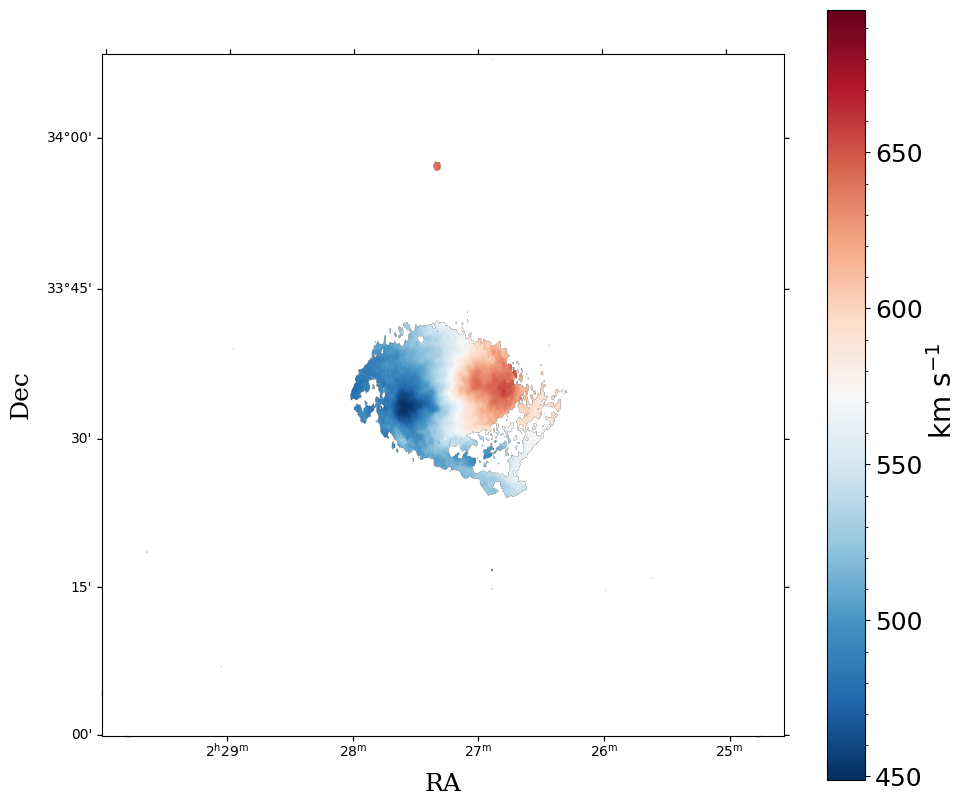

In [26]:
fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(1,1,1, projection=(WCS(h_mom1)))
cb = plt.imshow(d_mom1, cmap='RdBu_r')
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

cbar =fig.colorbar(cb)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_ylabel(r' km s$^{-1}$', fontsize=20)
plt.show()

# the rotation of the gas in the galaxy is clearly visible
# the red side is redshifted spectral lines -> the gas is moving away from us
# the blue side is blushifted lines -> the gas is moving towards us

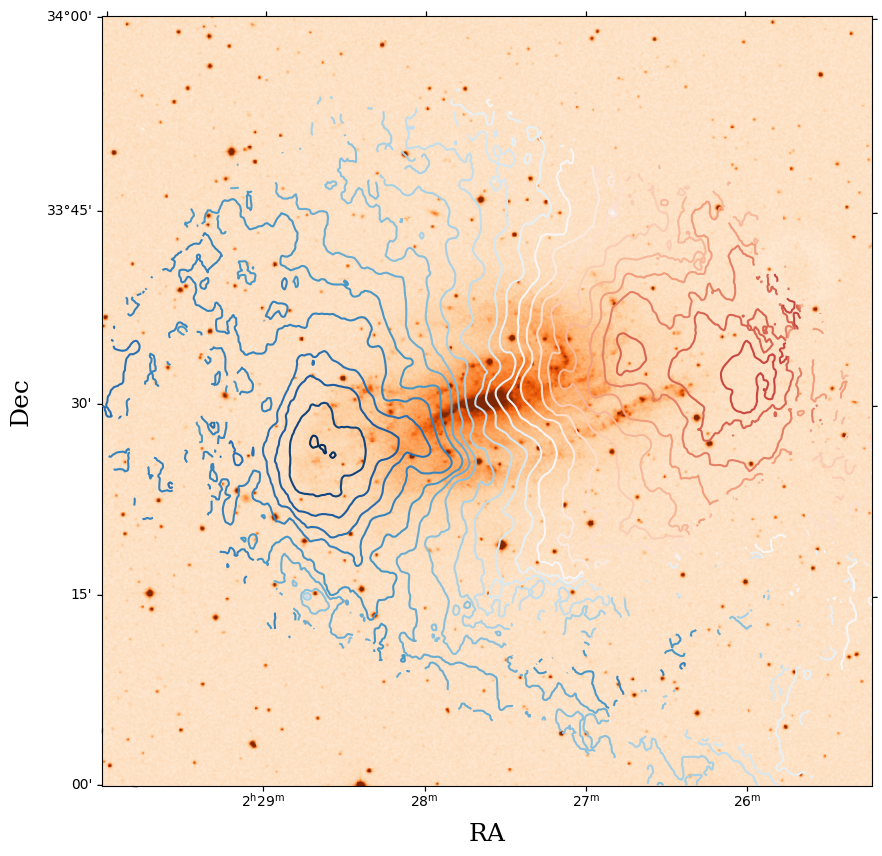

In [27]:
# To make an overlay with the velocity contours
hi_reprojected, footprint = reproject_interp(hdul_mom1, h_opt)

fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(1,1,1, projection=WCS(h_mom1))
ax.imshow(d_opt, cmap='Oranges', vmax=np.percentile(d_opt, 99.8))
ax.contour(hi_reprojected, levels=np.arange(450, 700, 10), cmap='RdBu_r')
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig.savefig(directory+'/ngc4192_mom1_overlay.png', dpi=200)